## Baroreflex as a Linear Control System

by Jeffrey Kantor  (jeff at nd.edu). The latest version of this notebook is available at [https://github.com/jckantor/CBE30338](https://github.com/jckantor/CBE30338). 

The [baroreflex](https://en.wikipedia.org/wiki/Baroreceptor) is one of several mechanisms in the body for maintaining arterial blood pressure (AP) at near constant levels. Specialized neurons, known as [baroreceptors](https://en.wikipedia.org/wiki/Baroreceptor), sense pressure through the stretching of the walls in key blood vessels. The signals are processed in the brainstem which, in turn, produces a compensating change in sympathetic and parasympathetic nervous system causing a response by the heart.  (Figure from Victor, 2015).

![baroreflex system](../images/nrcardio.2015.96-f2.jpg)

This notebook presents a linear control analysis of the closed-loop system consisting of a 'peripheral arc' from the sympathetic efferents connected to the heart tissue that cause the blood pressure to increase, and a corresponding 'neural arc' from the carotid baroreceptors sensing blood pressure to the sympathetic nervous response. Together these arcs comprise a closed-loop for the short-term control of blood pressure in the body (McLoone, 2014). 

This is diagrammed below in the form a closed loop control system

![baroreflex control diagram](../images/baroreflex.png)

where $AP$ refers to arterial blood pressure, and $SNA$ is the activity of the sympathetic nervous system correlated with response of the heart, $G_p$ represents the transfer function of the peripheral arc, and $G_c$ represents the transfer function of the neural (or control) arc.  The signal $p$ is placeholder for the influence of exogenous influences on blood pressure, such as a change in body body position. 

In [24]:
%matplotlib inline

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import control.matlab as control

sns.set_context('talk')

# needed to avoid a deprecation warning in the control library 
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

## Peripheral Arc

Transfer function models for the 'peripheral arc', denoted $G_p(s)$ in the closed-loop diagram, have been measured for various animal models. For anesthesized rats, for example, Chapius et al., 2004, found

$$G_p(jf) = \left(\frac{K}{1 + 2\lambda(f/f_n) + (j(f/f_n))^2}\right)\exp\left(-2\pi Tjf\right)$$

where $j$ is the imaginary operator $\sqrt{-1}$, and $f$ is frequency in units of Hertz. Reported values for the parameters are given in the following table.

| Parameter | Description | $\qquad\qquad$ Value $\qquad\qquad$ | Conversion |
| :--: | :- | :-: | :-: |
| $K$ | static gain | $1.16 \pm 0.21$ mmHg/% SNA | $K_p \approx 1.16$ mmHg/% SNA|
| $f_n$ | natural frequency | $0.089\pm 0.007$ Hz | $\tau \approx 1.79$ sec |
| $\lambda$ | damping coefficient | $1.23\pm 0.14$ | $\zeta \approx 1.23$
| $T$ | fixed time delay | $0.476\pm 0.020$ sec | $t_d \approx 0.476$ |

Using the indicated conversions of values and parameters, the literature model is recast into standard transfer function notation

$$G_p(s) =  \left(\frac{K_p}{\tau^2 s^2 + 2\zeta\tau s + 1}\right)\exp\left(-t_d s\right)$$

The following cell implements this transfer function using the [Python Control Systems Library](https://pypi.python.org/pypi/control/0.7.0).

In [25]:
Kp = 1.16                  # mmHg/%SNA
tau = 1.0/(2*0.089*np.pi)  # sec
zeta = 1.23
td = 0.476

Gp_ = control.tf([Kp],[tau**2,2*zeta*tau,1])
print('\nWithout Time Delay -->\n', Gp_)

num,den = control.pade(td,3)
Gp = Gp_ * control.tf(num,den)
print('\nWith a 3rd order Pade approximation for Time Delay -->\n', Gp)


Without Time Delay -->
 
          1.16
-----------------------
3.198 s^2 + 4.399 s + 1


With a 3rd order Pade approximation for Time Delay -->
 
           -1.16 s^3 + 29.24 s^2 - 307.2 s + 1291
------------------------------------------------------------
3.198 s^5 + 85.02 s^4 + 958.7 s^3 + 4748 s^2 + 5160 s + 1113



The following cell demonstrates the step response of the peripheral arc to a 1% change in $SNA$.

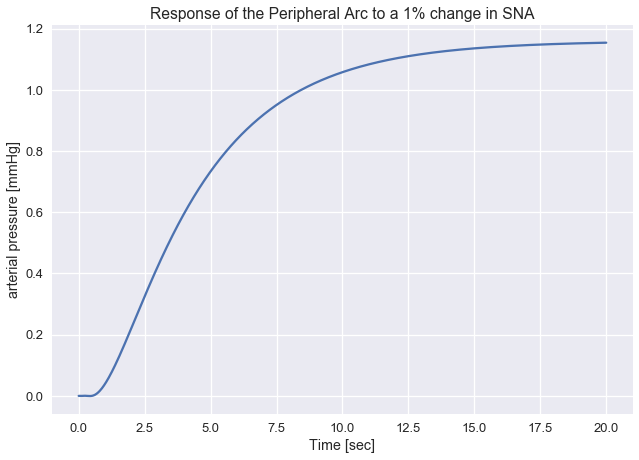

In [26]:
t = np.linspace(0,20,1000)
y,t = control.step(Gp,t)
plt.plot(t,y)
plt.xlabel('Time [sec]')
plt.ylabel('arterial pressure [mmHg]')
plt.title('Response of the Peripheral Arc to a 1% change in SNA');

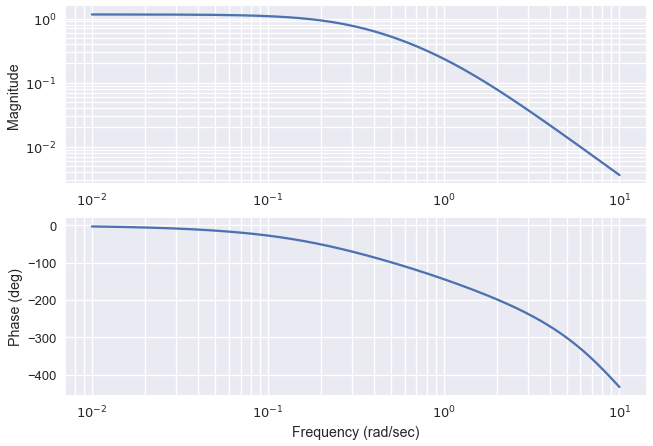

In [29]:
w = np.logspace(-2,1,300)
mag,phase,w = control.bode(Gp,w)

## P, PI, PD, and PID Control

Let's now consider how the baroreflex would behave if a controller were designed without regard to the underlying physiology.  For this purpose we'll consider the design of a PID control using tuning rules typical of practice in process control.

For coding convenience, we implement a utiity function that creates a transfer function for P, PI, PD, or PID control in standard form. The general expression is given by

$$ G_c^{PID}(s) = K_c\left[1 + \frac{1}{\tau_I s} + \frac{\tau_D s}{\alpha \tau_D s + 1}\right] $$

where the third term provides realizable derivative action. Parameter $\alpha \approx 0.1$ provides high-frequency roll-off of the derivative action.  When specialized and expressed over a common denominator, the specific forms of the controller become

\begin{align*}
G_c^{P} & = K_c \\
G_c^{PI} & = K_c \frac{\tau_Is + 1}{\tau_I s} \\
G_c^{PD} & = K_c \frac{(1+\alpha)\tau_D s + 1}{\alpha\tau_Ds + 1} \\
G_c^{PID} & = K_c\frac{(1+\alpha) \tau_I \tau_D s^2 + (\tau_I+\alpha\tau_D) s +  1}{\alpha \tau_I \tau_D s^2 + \tau_I s}
\end{align*}

In [39]:
def PID(Kc=1,tauI=0,tauD=0):
    alpha = 0.1
    Gc = control.tf([1],[1])
    if tauI != 0:
        Gc += control.tf([1],[1,0])
    if tauD != 0:
        Gc += control.tf([tauD,0],[alpha*tauD,1])
    return Kc*Gc

def P(Kc=1):
    return PID(Kc,0,0)

def PI(Kc=1,tauI=0):
    return PID(Kc,tauI,0)

def PD(Kc=1,tauD=0):
    return PID(Kc,0,tauD)

PID(1,1,1)


1.1 s^2 + 1.1 s + 1
-------------------
    0.1 s^2 + s

### Ziegler-Nichols Tuning

[Ziegler-Nichols tuning](https://en.wikipedia.org/wiki/Ziegler%E2%80%93Nichols_method) is a well known and widely used methods for determining an intial tuning of P, PI, PD, and PID controllers. The methods requires values of $K_{cu}$ (the proportional-only control gain at which a sustained oscillation is observed) and $P_u$ (the period of the observed oscillation). 

| Control Type | $K_p$ | $\tau_I$ | $\tau_D$ |
| :- | :-: | :-: | :-: |
| P | $0.5 K_u$ | - | - |
| PI | $0.45 K_u$ | $P_u$/$1.2$ | - |
| PD | $0.8 K_u$ | - | $P_u$/$8$ |
| classic PID | $0.6 K_u$ | $P_u$/$2$ | $P_u$/$8$ |
| Pessen Integral Rule | $0.7 K_u$ | $P_u$/$2.5$ | $3 P_u$/$20$ |
| some overshoot | $0.33 K_u$ | $P_u$/$2$ | $P_u$/$3$ |
| no overshoot | $0.2 K_u$ | $P_u$/$2$ | $P_u$/$3$ |

In the following cell, these values are obtained using the `margin` function from the Python Control Library, then verified by plotting a closed-loop step response using a proportional-only controller.

Ultimate Gain =  8.80991289154
Ultimate Period =  3.88965615063


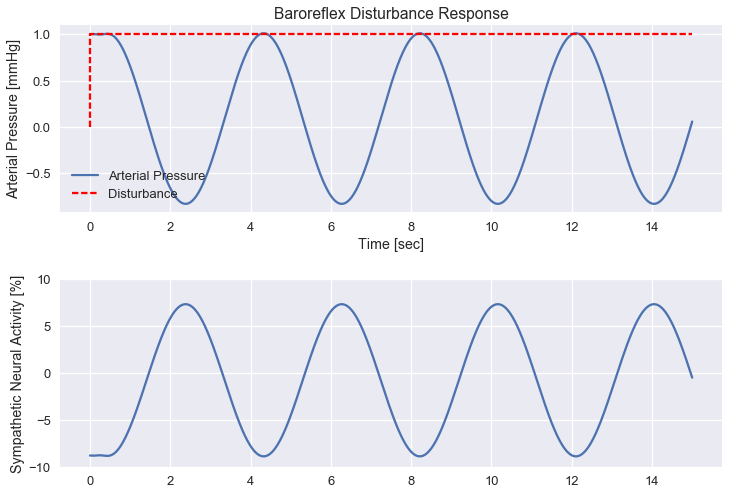

In [40]:
gm,pm,Wcg,Wcp = control.margin(Gp)
Kcu = gm
Pu = 2*np.pi/Wcp

print('Ultimate Gain = ', Kcu)
print('Ultimate Period = ', Pu)

def stepResponse(Gp,Gc,t):
    y,t = control.step(1/(1+Gp*Gc),t)
    u,t = control.step(-Gc/(1+Gp*Gc),t)
    plt.subplot(2,1,1)
    plt.plot(t,y,[0,0,max(t)],[0,1,1],'r--')
    plt.xlabel('Time [sec]')
    plt.ylabel('Arterial Pressure [mmHg]')
    plt.title('Baroreflex Disturbance Response')
    plt.legend(['Arterial Pressure','Disturbance'],loc='lower left')
    plt.subplot(2,1,2)
    plt.plot(t,u)
    plt.ylim(-10,10)
    plt.ylabel('Sympathetic Neural Activity [%]')
    plt.tight_layout()
         
t = np.linspace(0,15,1000)
stepResponse(Gp,PID(Kcu,0,0),t)

### Proportional-Derivative Control

Proportional-derivative control is generally associated with the suppression of peak overshoot in the disturbance response. The following shows the baroreflex response subject to PD control using a standard process control tuning rules.

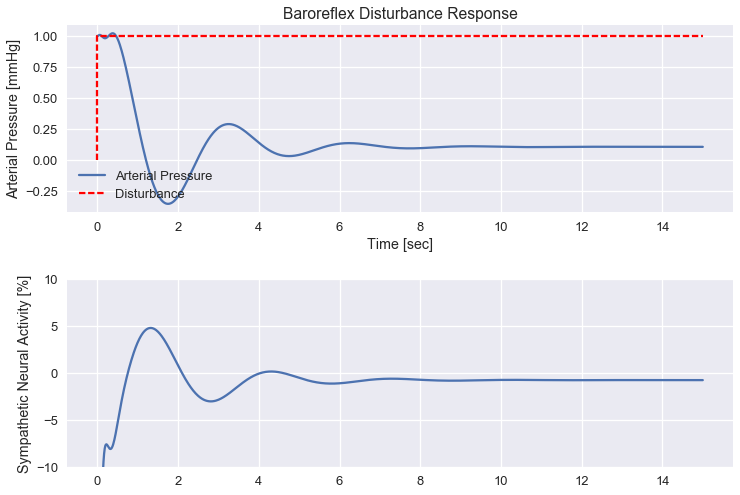

In [41]:
Gc = PID(0.8*Kcu,0,Pu/8)
stepResponse(Gp,Gc,t)

### Internal Model Control Tuning

Case J

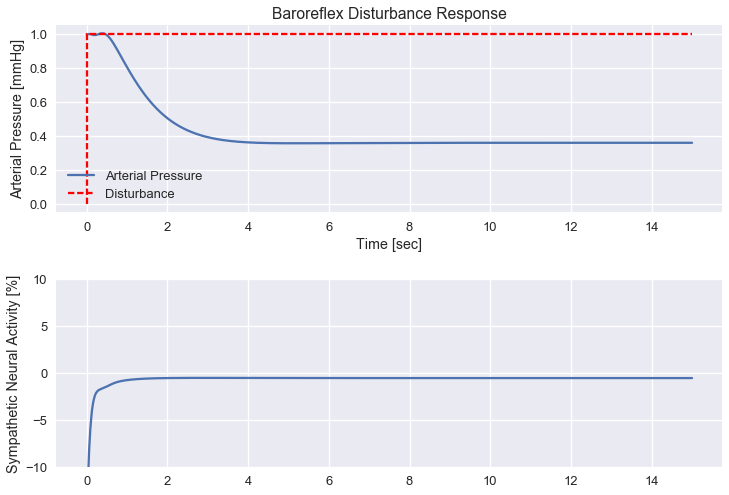

In [42]:
tauC = 2
Kc = (2*zeta*tau)/(tauC + td)/Kp
tauI = 2*zeta*tau
tauD = tau/(2*zeta)

GcIMC = PID(Kc,0,tauD)
t = np.linspace(0,15,1000)
stepResponse(Gp,GcIMC,t)

## Measured Physiological Response of Neural Arc

Petiot, et. al. (2001) (from the same laboratory cited above) provided laboratory measurements of the transfer function for the 'neural (or central) arc' for anesthesized rats. The results were given in the form

$$G_c^{Phys}(jf) = K\left(\frac{1+j(f/f_c)}{1 + 2\lambda j(f/fn)-(f/f_n)^2}\right)\exp\left(-2\pi jTf\right)$$

where $f$ is frequency in units of Hz. 

In the standard form for control engineering, the transfer function is written as

$$G_c^{Phys}(s) = K_c \frac{\tau_c s + 1}{\tau_n^2 s^2 + 2\lambda\tau_n s + 1} e^{-sT}$$

where $\tau = \frac{1}{2\pi f}$ and $s = 2\pi f$ are the conversions from frequency in Hz to time constant and Laplace variable $s$, respectively.

| Parameter | Description | $\qquad\qquad$ Value $\qquad\qquad$ | Conversion |
| :--: | :- | :-: | :-: |
| $K$ | static gain | 1.04 %SNA/mmHg | $K_c \approx$ 1.04 %SNA/mmHg|
| $f_c$ | corner frequency | 0.157 Hz | $\tau_c \approx$ 1.01 sec |
| $f_n$ | natural frequency | 1.12 Hz | $\tau_n \approx$ 0.142 sec |
| $\lambda$ | damping coefficient | 1.71 | $\zeta \approx$ 1.71 |
| $T$ | fixed time delay | 0.101 sec | $t_d \approx$ 0.101 sec|

1.0137257521776772 0.14210262776062083


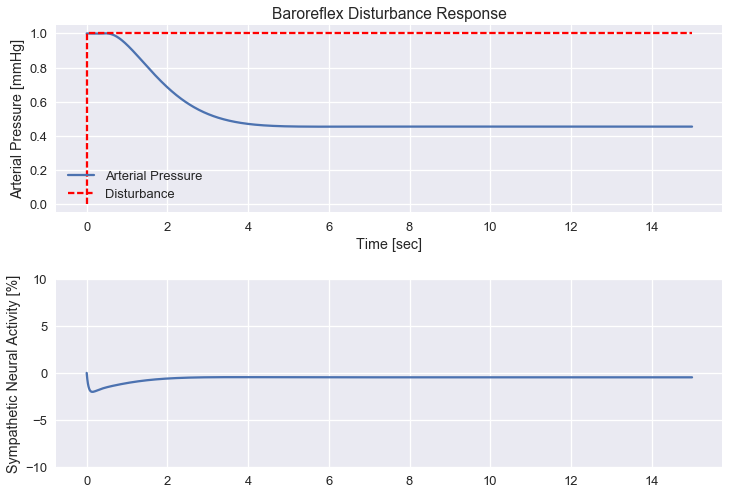

In [43]:
fc = 0.157
fn = 1.12
K = 1.04
zetac = 1.71
tdelay = 1.01

tauc = 1/(2*np.pi*fc)
taun = 1/(2*np.pi*fn)

print(tauc,taun)

num,den = control.pade(tdelay,3)

GcPhys = K*control.tf([tauc,1],[taun**2,2*zetac*taun,1])
stepResponse(Gp,GcPhys,t)

## Comparison of ZN Tuned PD Control to the Observed Physiological Response of the Neural arc

We observe a very different physiological behavior than what we naively predicted using a PD controller tuned using the Ziegler-Nichols rules.  To highlight these differences, the next cell compares the step responses of the two control laws

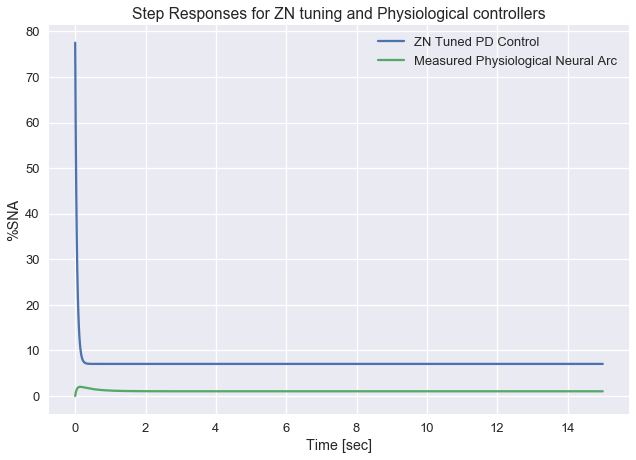

In [44]:
u,t = control.step(Gc,t)
uPhys,t = control.step(GcPhys,t)
plt.plot(t,u,t,uPhys)
plt.xlabel('Time [sec]')
plt.ylabel('%SNA')
plt.title('Step Responses for ZN tuning and Physiological controllers')
plt.legend(['ZN Tuned PD Control','Measured Physiological Neural Arc']);

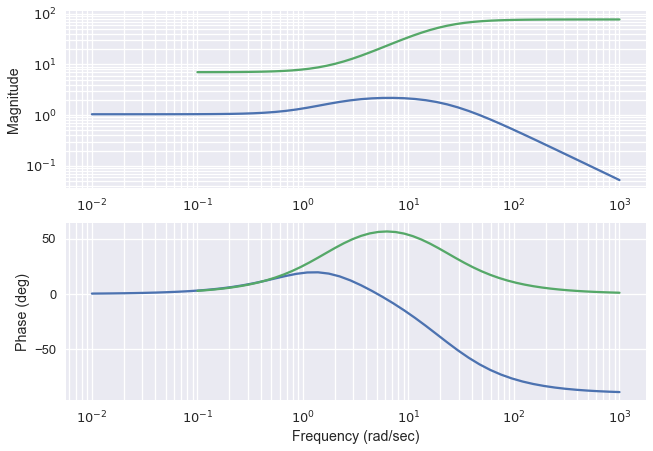

In [45]:
control.bode(GcPhys);
control.bode(Gc);

## Modifications to the PD Controller

Matching the Proportional-Derivative control law to the observed physiological response of the neural arc requires several modifications of the PD controller. The first step is to introduce a second-order filter to suppress the 'derivative kick' 

$$ G_c^{mod}(s) = K_c\left[1 + \frac{\tau_D s}{\alpha \tau_D s + 1}\right]\left[\frac{1}{\tau_n s + 1}\right]^2 $$

The second is to substantially reduce the control gain, and to slightly reduce the derivative time constant for a corresponding tuning $K_c = 0.12 K_{cu}$ and $\tau_D = P_u/6$. The following cells compares the computed baroreflex response with these modifications in place.

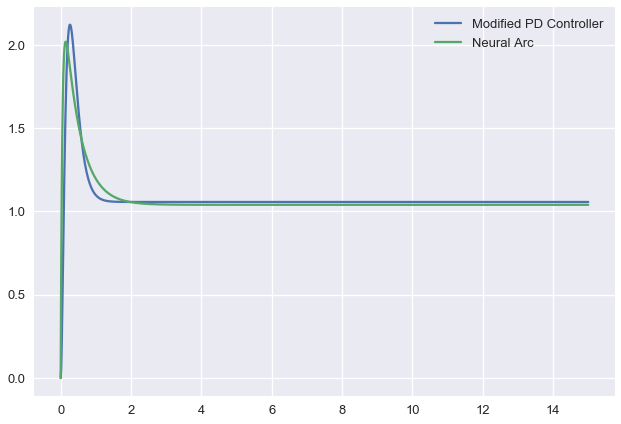

In [46]:
Gc = PID(0.12*Kcu,0,Pu/6)
Gcf = Gc*(control.tf([1],[1*taun,1]))**2
uf,t = control.step(Gcf,t)

uPhys,t = control.step(GcPhys,t)

plt.plot(t,uf,t,uPhys)
plt.legend(['Modified PD Controller','Neural Arc']);

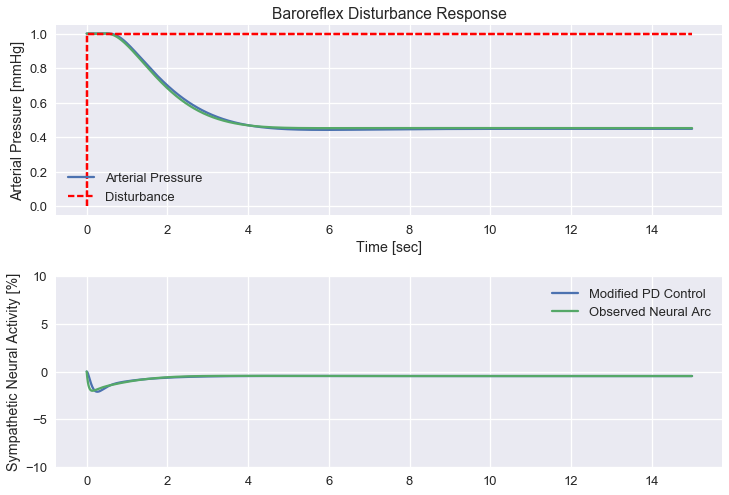

In [47]:
stepResponse(Gp,Gcf,t)
stepResponse(Gp,GcPhys,t)
plt.legend(['Modified PD Control','Observed Neural Arc']);

## Conclusions

To create a control response resembling the physiological response inferred from the cited papers, it was necessary to:

1. Introduce a filter to significantly reduce the 'derivative kick' associated with a standard PID control implementation.
2. Reduce the proportional gain by a factor of about 5 from a value that would be typically used in industrial process control.
3. There was no integral response observed in the physiologically consistent control.

### References


Chapuis, Bruno et al. “Linear Modelling Analysis of Baroreflex Control of Arterial Pressure Variability in Rats.” The Journal of Physiology 559.Pt 2 (2004): 639–649. PMC. Web. 29 Mar. 2017. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1665118/

Kamiya, Atsunori et al. “Closed-Loop Spontaneous Baroreflex Transfer Function Is Inappropriate for System Identification of Neural Arc but Partly Accurate for Peripheral Arc: Predictability Analysis.” The Journal of Physiology 589.Pt 7 (2011): 1769–1790. PMC. Web. 28 Mar. 2017.  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3099029/

Roy Kanbar, Valérie Oréa, Bruno Chapuis, Christian Barrès, Claude Julien
American Journal of Physiology - Regulatory, Integrative and Comparative Physiology Nov 2007, 293 (5) R1938-R1946; DOI: 10.1152/ajpregu.00374.2007  http://ajpregu.physiology.org/content/293/5/R1938.short

McLoone, Violeta. "Modelling of Long and Short Term Blood Pressure Control Systems." PhD Thesis, NUI Maynooth, 2014.  http://eprints.maynoothuniversity.ie/5611/1/Thesis_V_McLoone-Final_Version.pdf

Petiot, Emmanuelle et al. “Frequency Response of Renal Sympathetic Nervous Activity to Aortic Depressor Nerve Stimulation in the Anaesthetized Rat.” The Journal of Physiology 537.Pt 3 (2001): 949–959. PMC. Web. 29 Mar. 2017. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2278997/

Victor, Ronald G. "Carotid baroreflex activation therapy for resistant hypertension." Nature Reviews Cardiology 12, 451–463 (2015) doi:10.1038/nrcardio.2015.96 http://www.nature.com/nrcardio/journal/v12/n8/full/nrcardio.2015.96.html

